# PA Quantum Neuron

Build a classical neuron with a quantum circuit

In [6]:
from colorama import Fore, Back, Style 

import numpy as numpy
from pennylane import numpy as np
import pennylane as qml
from pennylane.optimize import NesterovMomentumOptimizer
from pennylane.math import requires_grad

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

from math import pi


# Quantum

In [7]:
max_iterations = 200
loop_count = 13

In [8]:

dev_1 = qml.device('default.qubit', wires=2)
dev_2 = qml.device('default.qubit', wires=2)
dev_3 = qml.device('default.qubit', wires=2)

## Classifier 1
init_weights_1 = (0.01 * np.random.randn(6), 0.0)

@qml.qnode(dev_1)
def circuit_1(weights, data):
    qml.Hadamard(0)
    qml.Hadamard(1)
    
    qml.RY(data[0], wires=0) # input feature 1
    qml.RY(data[1], wires=1) # input feature 2
    
    qml.CNOT(wires=[0, 1])
    
    qml.Rot(weights[0], weights[1], weights[2], wires=0)
    qml.Rot(weights[3], weights[4], weights[5], wires=1)
    
    qml.CNOT(wires=[0, 1])
    
    return qml.expval(qml.PauliZ(0))

def vc_classifier_1(var, data):
    weights = var[0]
    bias = var[1]
    return circuit_1(weights, data) + bias


## Classifier 2
init_weights_2 = (0.01 * np.random.randn(6), 0.0)

@qml.qnode(dev_2)
def circuit_2(weights, data):
    qml.Hadamard(0)
    qml.Hadamard(1)
    
    qml.RY(data[0], wires=0) # input feature 1
    qml.RX(data[1], wires=0) # input feature 2
    
    qml.CNOT(wires=[0, 1])
    
    qml.Rot(weights[0], weights[1], weights[2], wires=0)
    qml.Rot(weights[3], weights[4], weights[5], wires=1)
    
    qml.CNOT(wires=[0, 1])

    return qml.expval(qml.PauliZ(0))

def vc_classifier_2(var, data):
    weights = var[0]
    bias = var[1]
    return circuit_2(weights, data) + bias
  

## Classifier 3
init_weights_3 = (0.01 * np.random.randn(6), 0.0)

@qml.qnode(dev_3)
def circuit_3(weights, data):
    qml.Hadamard(0)
    qml.Hadamard(1)
    
    qml.RY(data[0], wires=0) # input feature 1
    qml.RX(data[1], wires=1) # input feature 2
    
    qml.CNOT(wires=[0, 1])
    
    qml.Rot(weights[0], weights[1], weights[2], wires=0)
    qml.Rot(weights[3], weights[4], weights[5], wires=1)
    
    qml.CNOT(wires=[0, 1])
    
    return qml.expval(qml.PauliZ(0))

def vc_classifier_3(var, data):
    weights = var[0]
    bias = var[1]
    return circuit_3(weights, data) + bias


## generic
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2
    loss = loss / len(labels)
    return loss

def cost(vc_classifier, weights, datas, labels):
    predictions = [vc_classifier(weights, f) for f in datas]
    return square_loss(labels, predictions)

def accuracy(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)
    return loss
  
def plot_costs(costs, num_layers):
  # plot costs
   fig, (ax1) = plt.subplots(1)
   fig.suptitle('Costs')
   ax1.plot(range(len(costs)), costs, label='Layers: {}'.format(num_layers))
   ax1.set_xlabel('iteration number')
   ax1.set_ylabel('cost objective function')
   ax1.legend(loc="upper right")
   plt.show()

# init weights
# var_init = (0.01 * np.random.randn(1, 2, 3), 0.0)


In [9]:
def vc_quantum(vc_classifier, init_weights, x_train, x_test, X, y_train, y_test, Y):
  opt = NesterovMomentumOptimizer(0.01)
  batch_size = 5
  var = init_weights
  iterations = max_iterations
  costs = np.zeros(iterations) 

  for it in range(iterations):

      # Update the weights by one optimizer step
      batch_index = np.random.randint(0, len(x_train), (batch_size,))
      feats_train_batch = x_train[batch_index]
      Y_train_batch = y_train[batch_index]
      var, stepCost = opt.step_and_cost(lambda v: cost(vc_classifier, v, feats_train_batch, Y_train_batch), var)

      # Compute predictions on train and validation set
      predictions_train = [np.sign(vc_classifier(var, f)) for f in x_train]
      predictions_val = [np.sign(vc_classifier(var, f)) for f in x_test]
      predictions_all = [np.sign(vc_classifier(var, f)) for f in X]

      # Compute accuracy on train and validation set
      acc_train = accuracy(y_train, predictions_train)
      acc_val = accuracy(y_test, predictions_val)
      acc_all = accuracy(Y, predictions_all)

      # gather informations for plotting
      costs[it] = cost(vc_classifier, var, X, Y)

      print(
          "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc val: {:0.7f} | Acc all: {:0.7f} "
          "".format(it + 1, costs[it], acc_train, acc_val, acc_all)
      )
  
  return [var, acc_val]

# plot costs
# plot_costs(costs, 0)

Loop count: 0


C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 0.4292028 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9200000 
Iter:     2 | Cost: 0.4270595 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9400000 
Iter:     3 | Cost: 0.4285712 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9200000 
Iter:     4 | Cost: 0.4294841 | Acc train: 0.9333333 | Acc val: 0.9200000 | Acc all: 0.9200000 
Iter:     5 | Cost: 0.4301317 | Acc train: 0.9333333 | Acc val: 0.9200000 | Acc all: 0.9200000 
Iter:     6 | Cost: 0.4378575 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.8900000 
Iter:     7 | Cost: 0.4474263 | Acc train: 0.8666667 | Acc val: 0.9200000 | Acc all: 0.8800000 
Iter:     8 | Cost: 0.4609959 | Acc train: 0.8666667 | Acc val: 0.8800000 | Acc all: 0.8700000 
Iter:     9 | Cost: 0.4704369 | Acc train: 0.8666667 | Acc val: 0.8800000 | Acc all: 0.8700000 
Iter:    10 | Cost: 0.4768524 | Acc train: 0.8666667 | Acc val: 0.8800000 | Acc all: 0.8600000 
Iter:    11 | Cost: 0.4883142 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.2221855 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.2243031 | Acc train: 0.5200000 | Acc val: 0.3600000 | Acc all: 0.4700000 
Iter:     3 | Cost: 1.2310373 | Acc train: 0.4800000 | Acc val: 0.3600000 | Acc all: 0.4500000 
Iter:     4 | Cost: 1.2334628 | Acc train: 0.4800000 | Acc val: 0.3600000 | Acc all: 0.4500000 
Iter:     5 | Cost: 1.2316270 | Acc train: 0.4800000 | Acc val: 0.3600000 | Acc all: 0.4500000 
Iter:     6 | Cost: 1.2338521 | Acc train: 0.4800000 | Acc val: 0.3600000 | Acc all: 0.4500000 
Iter:     7 | Cost: 1.2366152 | Acc train: 0.4800000 | Acc val: 0.3600000 | Acc all: 0.4400000 
Iter:     8 | Cost: 1.2329210 | Acc train: 0.4800000 | Acc val: 0.3600000 | Acc all: 0.4400000 
Iter:     9 | Cost: 1.2221669 | Acc train: 0.4933333 | Acc val: 0.3600000 | Acc all: 0.4500000 
Iter:    10 | Cost: 1.2140549 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5000000 
Iter:    11 | Cost: 1.2100435 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6804613 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     2 | Cost: 1.6796181 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:     3 | Cost: 1.6792500 | Acc train: 0.3466667 | Acc val: 0.3600000 | Acc all: 0.3500000 
Iter:     4 | Cost: 1.6807233 | Acc train: 0.3600000 | Acc val: 0.3200000 | Acc all: 0.3500000 
Iter:     5 | Cost: 1.6869725 | Acc train: 0.3200000 | Acc val: 0.3200000 | Acc all: 0.3200000 
Iter:     6 | Cost: 1.6895388 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:     7 | Cost: 1.6892900 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:     8 | Cost: 1.6865681 | Acc train: 0.3200000 | Acc val: 0.3200000 | Acc all: 0.3200000 
Iter:     9 | Cost: 1.6854373 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:    10 | Cost: 1.6872373 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:    11 | Cost: 1.6888069 | Acc trai

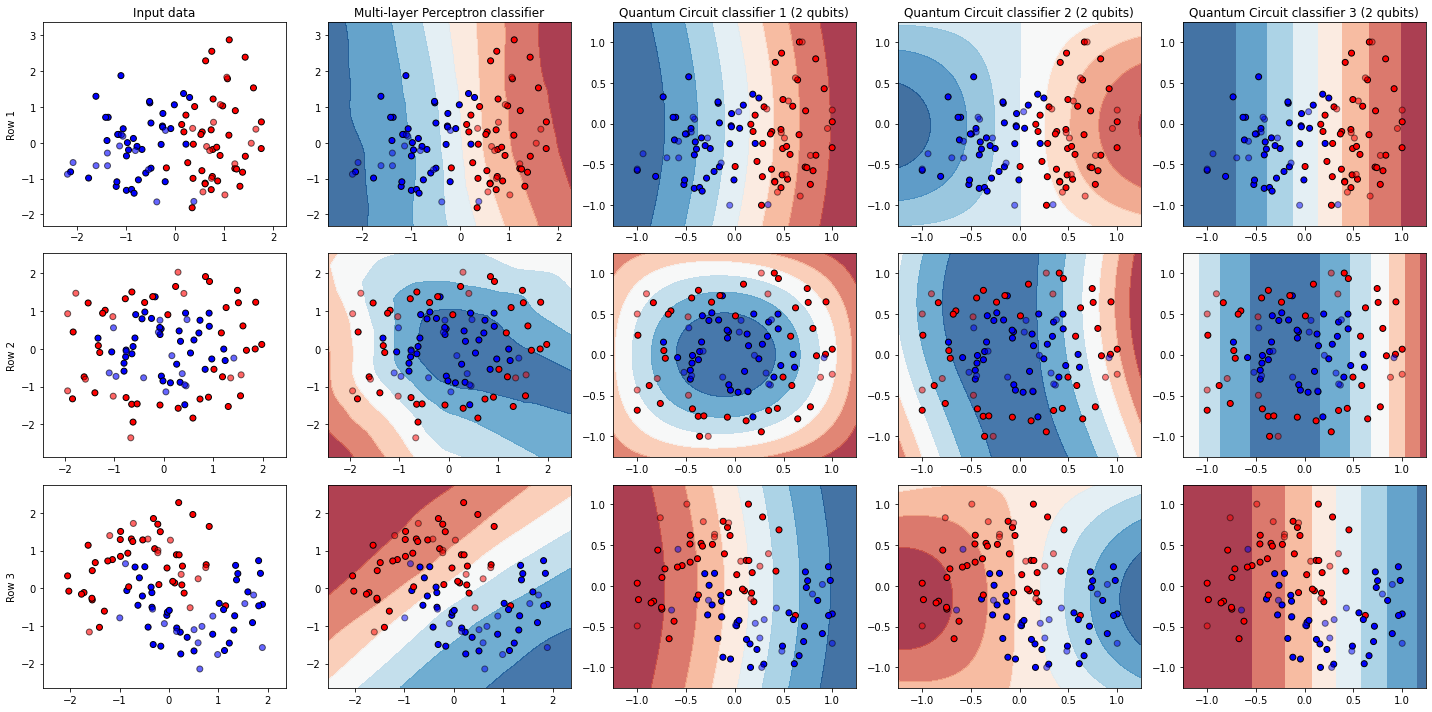

Loop count: 1


C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 0.4327222 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9200000 
Iter:     2 | Cost: 0.4322741 | Acc train: 0.9333333 | Acc val: 0.9200000 | Acc all: 0.9200000 
Iter:     3 | Cost: 0.4295968 | Acc train: 0.9333333 | Acc val: 0.9200000 | Acc all: 0.9200000 
Iter:     4 | Cost: 0.4263491 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9400000 
Iter:     5 | Cost: 0.4212507 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9300000 
Iter:     6 | Cost: 0.4192636 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:     7 | Cost: 0.4173415 | Acc train: 0.9466667 | Acc val: 0.9600000 | Acc all: 0.9500000 
Iter:     8 | Cost: 0.4174306 | Acc train: 0.9466667 | Acc val: 0.9600000 | Acc all: 0.9500000 
Iter:     9 | Cost: 0.4199137 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:    10 | Cost: 0.4247034 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:    11 | Cost: 0.4359534 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.2205514 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.2209888 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.2179742 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:     4 | Cost: 1.2150573 | Acc train: 0.5200000 | Acc val: 0.3600000 | Acc all: 0.5200000 
Iter:     5 | Cost: 1.2128277 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:     6 | Cost: 1.2111157 | Acc train: 0.5333333 | Acc val: 0.4400000 | Acc all: 0.5200000 
Iter:     7 | Cost: 1.2122345 | Acc train: 0.5333333 | Acc val: 0.4400000 | Acc all: 0.5300000 
Iter:     8 | Cost: 1.2164641 | Acc train: 0.5600000 | Acc val: 0.4800000 | Acc all: 0.5500000 
Iter:     9 | Cost: 1.2182294 | Acc train: 0.5600000 | Acc val: 0.4800000 | Acc all: 0.5500000 
Iter:    10 | Cost: 1.2261337 | Acc train: 0.5866667 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:    11 | Cost: 1.2373105 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6807121 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     2 | Cost: 1.6828051 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     3 | Cost: 1.6848212 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     4 | Cost: 1.6872294 | Acc train: 0.3466667 | Acc val: 0.3600000 | Acc all: 0.3600000 
Iter:     5 | Cost: 1.6897468 | Acc train: 0.3600000 | Acc val: 0.3600000 | Acc all: 0.3700000 
Iter:     6 | Cost: 1.6911161 | Acc train: 0.3600000 | Acc val: 0.3600000 | Acc all: 0.3700000 
Iter:     7 | Cost: 1.6917031 | Acc train: 0.3733333 | Acc val: 0.3600000 | Acc all: 0.3800000 
Iter:     8 | Cost: 1.6955978 | Acc train: 0.3733333 | Acc val: 0.3600000 | Acc all: 0.3600000 
Iter:     9 | Cost: 1.6947855 | Acc train: 0.3600000 | Acc val: 0.3600000 | Acc all: 0.3500000 
Iter:    10 | Cost: 1.6946143 | Acc train: 0.3466667 | Acc val: 0.3200000 | Acc all: 0.3500000 
Iter:    11 | Cost: 1.6963957 | Acc trai

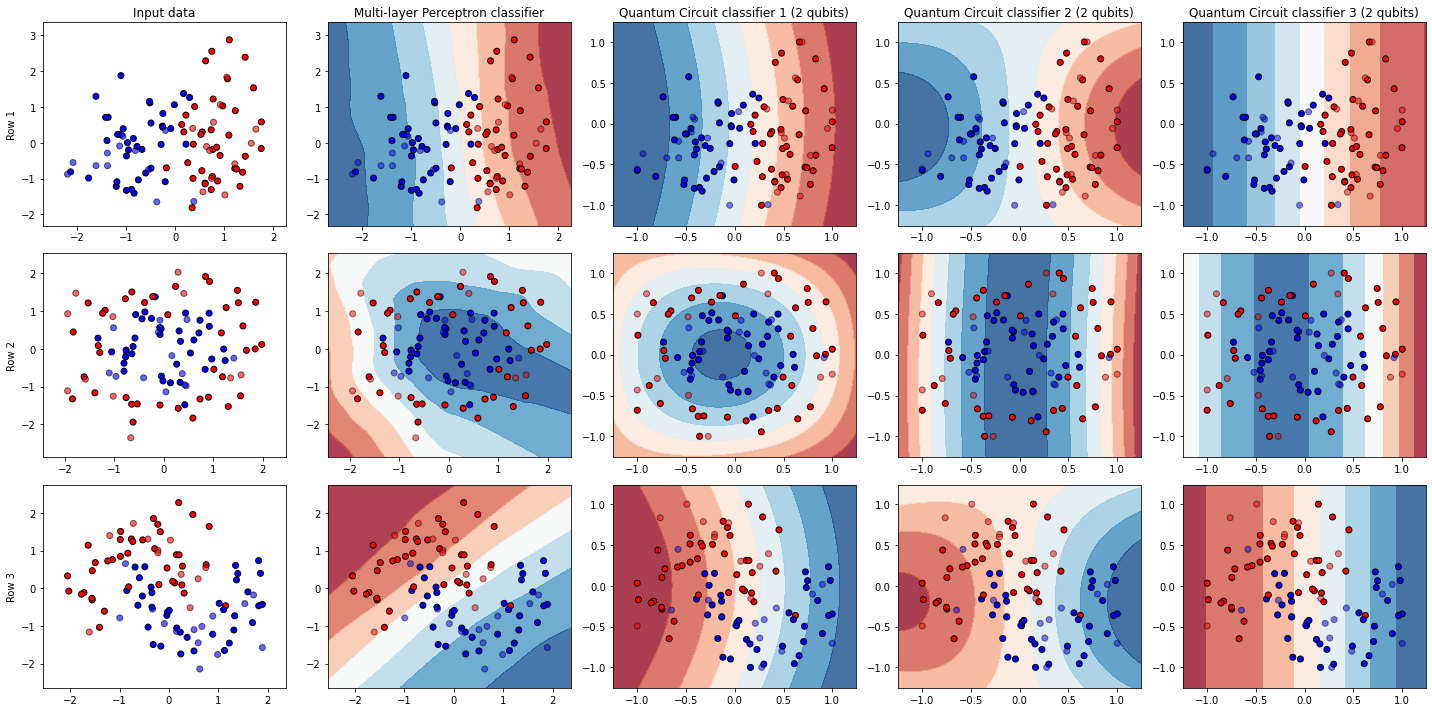

Loop count: 2


C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 0.4274817 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9400000 
Iter:     2 | Cost: 0.4233312 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9300000 
Iter:     3 | Cost: 0.4206452 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9300000 
Iter:     4 | Cost: 0.4196851 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:     5 | Cost: 0.4176065 | Acc train: 0.9466667 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:     6 | Cost: 0.4168348 | Acc train: 0.9466667 | Acc val: 0.9600000 | Acc all: 0.9500000 
Iter:     7 | Cost: 0.4167189 | Acc train: 0.9466667 | Acc val: 0.9600000 | Acc all: 0.9500000 
Iter:     8 | Cost: 0.4168692 | Acc train: 0.9466667 | Acc val: 0.9600000 | Acc all: 0.9500000 
Iter:     9 | Cost: 0.4168827 | Acc train: 0.9466667 | Acc val: 0.9600000 | Acc all: 0.9500000 
Iter:    10 | Cost: 0.4169550 | Acc train: 0.9466667 | Acc val: 0.9600000 | Acc all: 0.9500000 
Iter:    11 | Cost: 0.4167204 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.2177598 | Acc train: 0.5200000 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.2161229 | Acc train: 0.5200000 | Acc val: 0.3600000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.2150652 | Acc train: 0.5200000 | Acc val: 0.3600000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.2151831 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:     5 | Cost: 1.2143262 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:     6 | Cost: 1.2131757 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:     7 | Cost: 1.2110091 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:     8 | Cost: 1.2070985 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:     9 | Cost: 1.2021830 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:    10 | Cost: 1.1983768 | Acc train: 0.5333333 | Acc val: 0.4000000 | Acc all: 0.5200000 
Iter:    11 | Cost: 1.1956165 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6827034 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     2 | Cost: 1.6846998 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     3 | Cost: 1.6900448 | Acc train: 0.3600000 | Acc val: 0.3600000 | Acc all: 0.3700000 
Iter:     4 | Cost: 1.6935458 | Acc train: 0.3733333 | Acc val: 0.3600000 | Acc all: 0.3800000 
Iter:     5 | Cost: 1.7002648 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:     6 | Cost: 1.7130765 | Acc train: 0.3200000 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:     7 | Cost: 1.7209919 | Acc train: 0.3066667 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     8 | Cost: 1.7195137 | Acc train: 0.3066667 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     9 | Cost: 1.7097751 | Acc train: 0.3200000 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:    10 | Cost: 1.7085248 | Acc train: 0.3200000 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:    11 | Cost: 1.6963497 | Acc trai

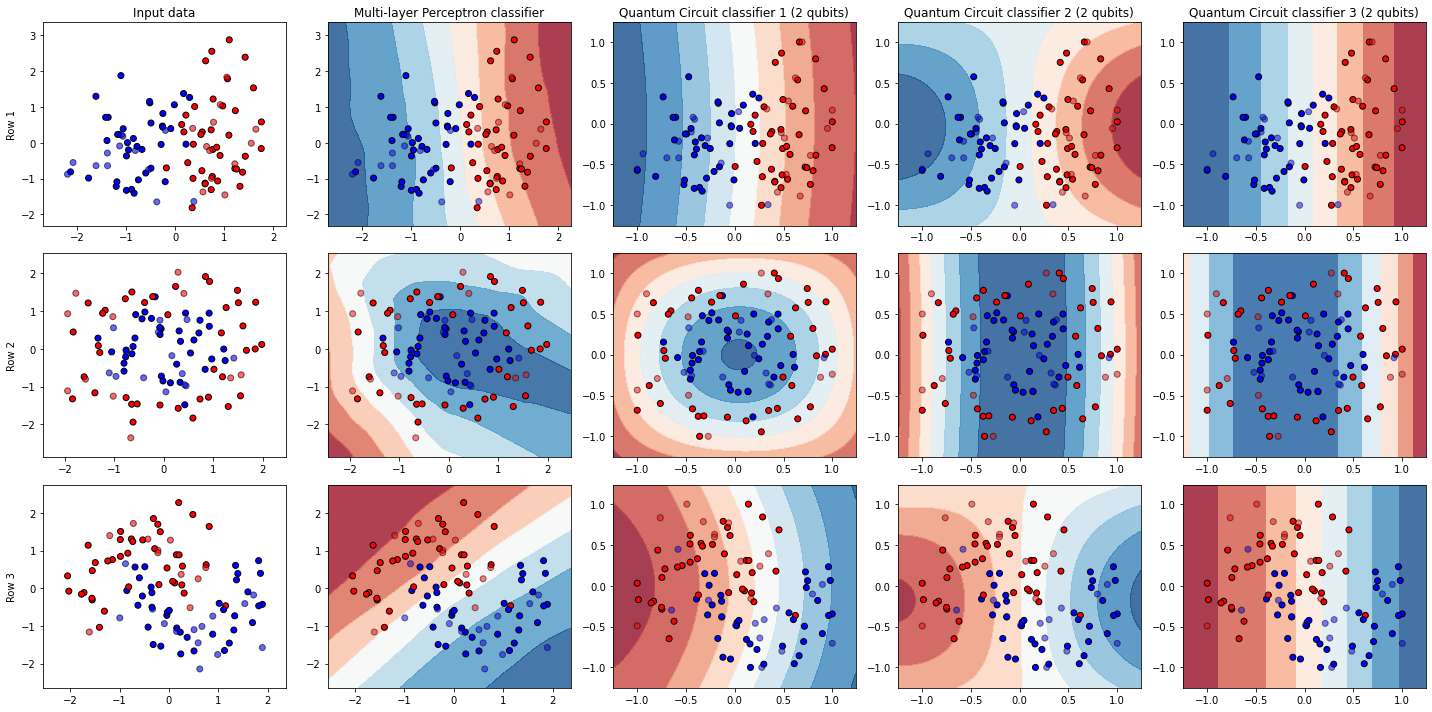

Loop count: 3


C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 0.4300627 | Acc train: 0.9333333 | Acc val: 0.9200000 | Acc all: 0.9200000 
Iter:     2 | Cost: 0.4312537 | Acc train: 0.9333333 | Acc val: 0.9200000 | Acc all: 0.9200000 
Iter:     3 | Cost: 0.4294302 | Acc train: 0.9333333 | Acc val: 0.9200000 | Acc all: 0.9200000 
Iter:     4 | Cost: 0.4277416 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9400000 
Iter:     5 | Cost: 0.4250729 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9300000 
Iter:     6 | Cost: 0.4231559 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9300000 
Iter:     7 | Cost: 0.4228528 | Acc train: 0.9200000 | Acc val: 0.9600000 | Acc all: 0.9300000 
Iter:     8 | Cost: 0.4234468 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9300000 
Iter:     9 | Cost: 0.4230903 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9300000 
Iter:    10 | Cost: 0.4223221 | Acc train: 0.9200000 | Acc val: 0.9600000 | Acc all: 0.9300000 
Iter:    11 | Cost: 0.4208296 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.2178875 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.2170820 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.2165159 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:     4 | Cost: 1.2174797 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.2207832 | Acc train: 0.5200000 | Acc val: 0.3600000 | Acc all: 0.4700000 
Iter:     6 | Cost: 1.2271053 | Acc train: 0.4800000 | Acc val: 0.3600000 | Acc all: 0.4500000 
Iter:     7 | Cost: 1.2320046 | Acc train: 0.4800000 | Acc val: 0.3600000 | Acc all: 0.4400000 
Iter:     8 | Cost: 1.2367734 | Acc train: 0.4666667 | Acc val: 0.3200000 | Acc all: 0.4500000 
Iter:     9 | Cost: 1.2455232 | Acc train: 0.4800000 | Acc val: 0.3200000 | Acc all: 0.4400000 
Iter:    10 | Cost: 1.2479385 | Acc train: 0.4666667 | Acc val: 0.3200000 | Acc all: 0.4400000 
Iter:    11 | Cost: 1.2569232 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6822679 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     2 | Cost: 1.6842688 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     3 | Cost: 1.6862029 | Acc train: 0.3466667 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:     4 | Cost: 1.6874811 | Acc train: 0.3466667 | Acc val: 0.3600000 | Acc all: 0.3500000 
Iter:     5 | Cost: 1.6880394 | Acc train: 0.3466667 | Acc val: 0.3600000 | Acc all: 0.3600000 
Iter:     6 | Cost: 1.6879811 | Acc train: 0.3466667 | Acc val: 0.3600000 | Acc all: 0.3600000 
Iter:     7 | Cost: 1.6895474 | Acc train: 0.3600000 | Acc val: 0.3600000 | Acc all: 0.3700000 
Iter:     8 | Cost: 1.7005216 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:     9 | Cost: 1.7149288 | Acc train: 0.3200000 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:    10 | Cost: 1.7413306 | Acc train: 0.2933333 | Acc val: 0.4000000 | Acc all: 0.3200000 
Iter:    11 | Cost: 1.7496653 | Acc trai

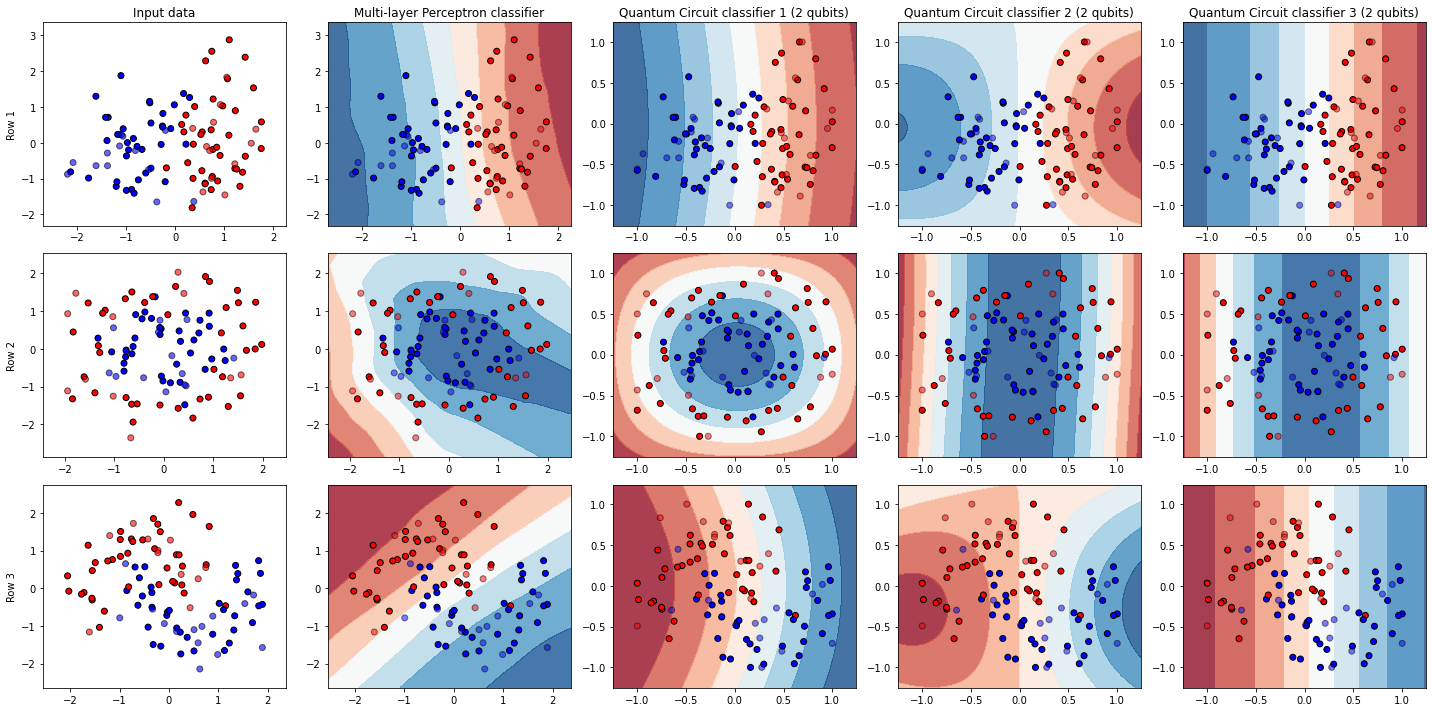

Loop count: 4


C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 0.4280836 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9400000 
Iter:     2 | Cost: 0.4276358 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9400000 
Iter:     3 | Cost: 0.4273394 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9400000 
Iter:     4 | Cost: 0.4273631 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9400000 
Iter:     5 | Cost: 0.4282385 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9200000 
Iter:     6 | Cost: 0.4265957 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9400000 
Iter:     7 | Cost: 0.4255257 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9300000 
Iter:     8 | Cost: 0.4241947 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9300000 
Iter:     9 | Cost: 0.4243701 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9300000 
Iter:    10 | Cost: 0.4239854 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9300000 
Iter:    11 | Cost: 0.4210035 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.2184517 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.2175017 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.2155350 | Acc train: 0.5200000 | Acc val: 0.3600000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.2132250 | Acc train: 0.5333333 | Acc val: 0.4000000 | Acc all: 0.5100000 
Iter:     5 | Cost: 1.2116265 | Acc train: 0.5333333 | Acc val: 0.4400000 | Acc all: 0.5300000 
Iter:     6 | Cost: 1.2107762 | Acc train: 0.5466667 | Acc val: 0.4400000 | Acc all: 0.5300000 
Iter:     7 | Cost: 1.2089989 | Acc train: 0.5333333 | Acc val: 0.4400000 | Acc all: 0.5300000 
Iter:     8 | Cost: 1.2073548 | Acc train: 0.5466667 | Acc val: 0.4400000 | Acc all: 0.5400000 
Iter:     9 | Cost: 1.2068360 | Acc train: 0.5600000 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:    10 | Cost: 1.2043993 | Acc train: 0.5600000 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:    11 | Cost: 1.2022428 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6796702 | Acc train: 0.3333333 | Acc val: 0.3600000 | Acc all: 0.3400000 
Iter:     2 | Cost: 1.6801629 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:     3 | Cost: 1.6820058 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     4 | Cost: 1.6868166 | Acc train: 0.3466667 | Acc val: 0.3600000 | Acc all: 0.3400000 
Iter:     5 | Cost: 1.6920941 | Acc train: 0.3600000 | Acc val: 0.3600000 | Acc all: 0.3700000 
Iter:     6 | Cost: 1.7040217 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:     7 | Cost: 1.7245254 | Acc train: 0.3066667 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     8 | Cost: 1.7576569 | Acc train: 0.2800000 | Acc val: 0.3600000 | Acc all: 0.3100000 
Iter:     9 | Cost: 1.7936098 | Acc train: 0.2933333 | Acc val: 0.4000000 | Acc all: 0.3300000 
Iter:    10 | Cost: 1.8348014 | Acc train: 0.3066667 | Acc val: 0.4000000 | Acc all: 0.3300000 
Iter:    11 | Cost: 1.8841233 | Acc trai

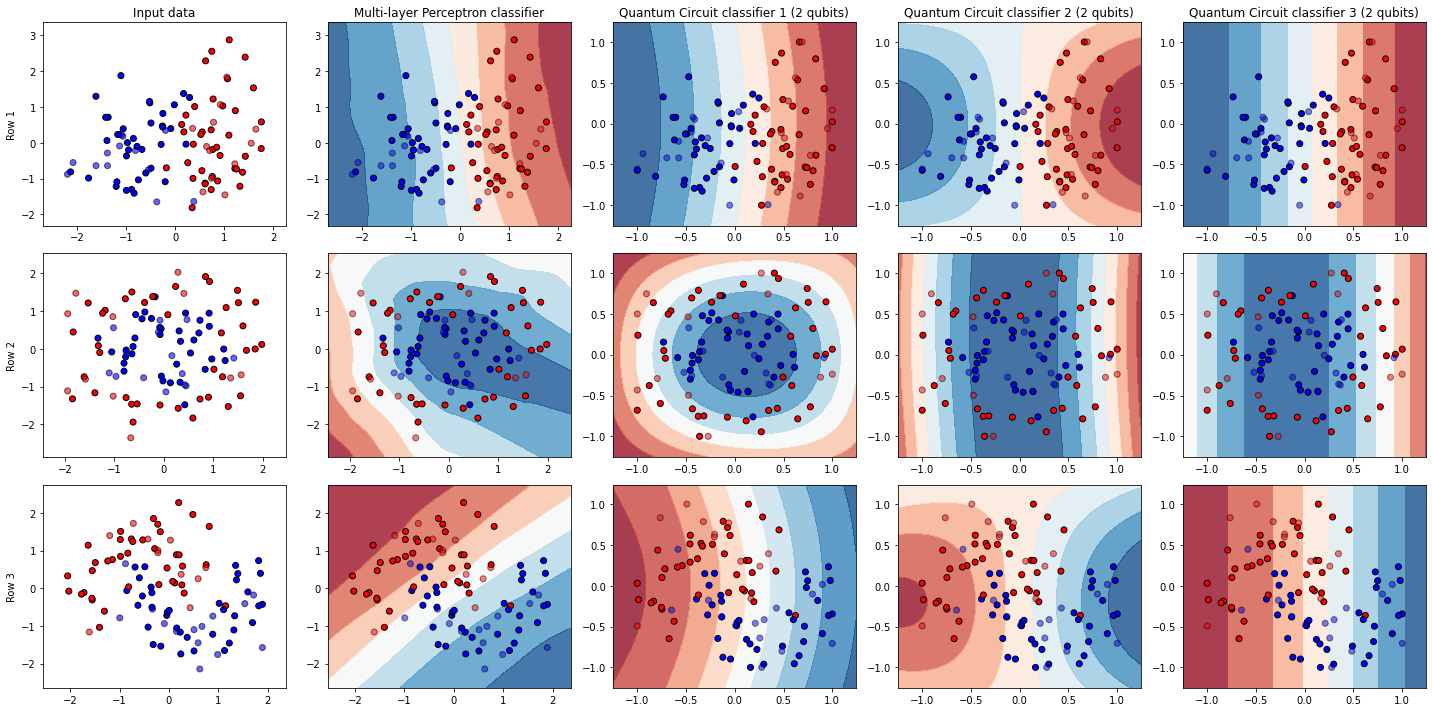

Loop count: 5


C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 0.4279715 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9400000 
Iter:     2 | Cost: 0.4271915 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9400000 
Iter:     3 | Cost: 0.4287811 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9200000 
Iter:     4 | Cost: 0.4287964 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9200000 
Iter:     5 | Cost: 0.4268745 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9400000 
Iter:     6 | Cost: 0.4235930 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9300000 
Iter:     7 | Cost: 0.4204702 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9300000 
Iter:     8 | Cost: 0.4187066 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:     9 | Cost: 0.4179435 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:    10 | Cost: 0.4179492 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:    11 | Cost: 0.4184251 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.2203226 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.2219620 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.4800000 
Iter:     3 | Cost: 1.2224581 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.4800000 
Iter:     4 | Cost: 1.2211035 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.4800000 
Iter:     5 | Cost: 1.2194436 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.4900000 
Iter:     6 | Cost: 1.2190395 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.4800000 
Iter:     7 | Cost: 1.2152901 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5000000 
Iter:     8 | Cost: 1.2095146 | Acc train: 0.5200000 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:     9 | Cost: 1.2068869 | Acc train: 0.5200000 | Acc val: 0.3600000 | Acc all: 0.5200000 
Iter:    10 | Cost: 1.2056938 | Acc train: 0.5200000 | Acc val: 0.3600000 | Acc all: 0.5200000 
Iter:    11 | Cost: 1.2052056 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6796551 | Acc train: 0.3466667 | Acc val: 0.3600000 | Acc all: 0.3500000 
Iter:     2 | Cost: 1.6798466 | Acc train: 0.3466667 | Acc val: 0.3600000 | Acc all: 0.3500000 
Iter:     3 | Cost: 1.6799230 | Acc train: 0.3466667 | Acc val: 0.3600000 | Acc all: 0.3500000 
Iter:     4 | Cost: 1.6805953 | Acc train: 0.3600000 | Acc val: 0.3600000 | Acc all: 0.3600000 
Iter:     5 | Cost: 1.6800769 | Acc train: 0.3466667 | Acc val: 0.3600000 | Acc all: 0.3500000 
Iter:     6 | Cost: 1.6798659 | Acc train: 0.3466667 | Acc val: 0.3600000 | Acc all: 0.3500000 
Iter:     7 | Cost: 1.6797350 | Acc train: 0.3333333 | Acc val: 0.3600000 | Acc all: 0.3400000 
Iter:     8 | Cost: 1.6795609 | Acc train: 0.3466667 | Acc val: 0.3600000 | Acc all: 0.3500000 
Iter:     9 | Cost: 1.6797133 | Acc train: 0.3600000 | Acc val: 0.3600000 | Acc all: 0.3600000 
Iter:    10 | Cost: 1.6792065 | Acc train: 0.3466667 | Acc val: 0.3600000 | Acc all: 0.3500000 
Iter:    11 | Cost: 1.6788597 | Acc trai

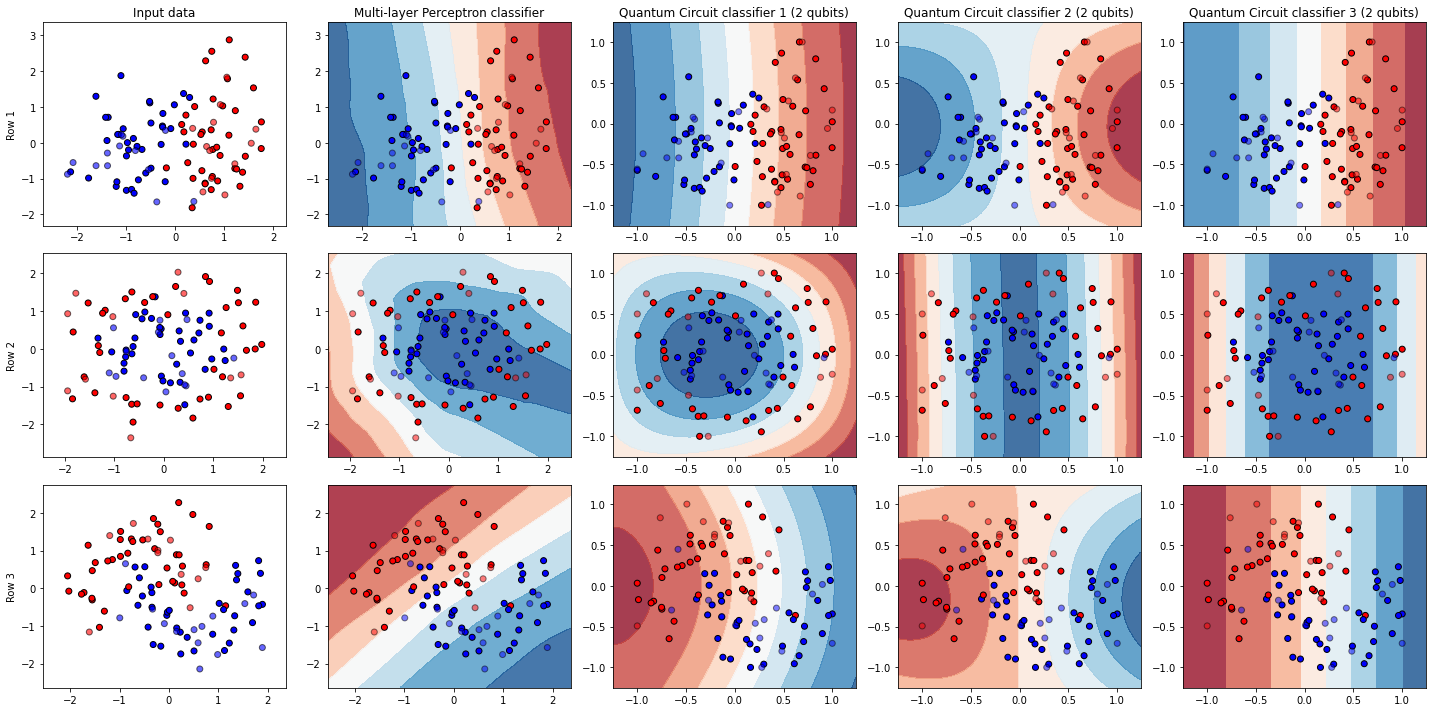

Loop count: 6


C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 0.4255792 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9300000 
Iter:     2 | Cost: 0.4222507 | Acc train: 0.9200000 | Acc val: 0.9600000 | Acc all: 0.9300000 
Iter:     3 | Cost: 0.4192302 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:     4 | Cost: 0.4182152 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:     5 | Cost: 0.4176266 | Acc train: 0.9466667 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:     6 | Cost: 0.4170784 | Acc train: 0.9466667 | Acc val: 0.9600000 | Acc all: 0.9500000 
Iter:     7 | Cost: 0.4168482 | Acc train: 0.9466667 | Acc val: 0.9600000 | Acc all: 0.9500000 
Iter:     8 | Cost: 0.4178572 | Acc train: 0.9466667 | Acc val: 0.9600000 | Acc all: 0.9500000 
Iter:     9 | Cost: 0.4207435 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:    10 | Cost: 0.4261312 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:    11 | Cost: 0.4286201 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.2176481 | Acc train: 0.5200000 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.2166709 | Acc train: 0.5200000 | Acc val: 0.3600000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.2150225 | Acc train: 0.5200000 | Acc val: 0.3600000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.2145107 | Acc train: 0.5200000 | Acc val: 0.3600000 | Acc all: 0.5200000 
Iter:     5 | Cost: 1.2124853 | Acc train: 0.5200000 | Acc val: 0.3600000 | Acc all: 0.5200000 
Iter:     6 | Cost: 1.2106058 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:     7 | Cost: 1.2086267 | Acc train: 0.5333333 | Acc val: 0.4000000 | Acc all: 0.5100000 
Iter:     8 | Cost: 1.2063912 | Acc train: 0.5333333 | Acc val: 0.4000000 | Acc all: 0.5200000 
Iter:     9 | Cost: 1.2041109 | Acc train: 0.5333333 | Acc val: 0.4000000 | Acc all: 0.5100000 
Iter:    10 | Cost: 1.2010352 | Acc train: 0.5333333 | Acc val: 0.4000000 | Acc all: 0.5200000 
Iter:    11 | Cost: 1.1978782 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6796657 | Acc train: 0.3333333 | Acc val: 0.3600000 | Acc all: 0.3400000 
Iter:     2 | Cost: 1.6802516 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     3 | Cost: 1.6800111 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:     4 | Cost: 1.6804581 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     5 | Cost: 1.6819079 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     6 | Cost: 1.6833586 | Acc train: 0.3466667 | Acc val: 0.3200000 | Acc all: 0.3200000 
Iter:     7 | Cost: 1.6825287 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     8 | Cost: 1.6826676 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3200000 
Iter:     9 | Cost: 1.6837664 | Acc train: 0.3466667 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:    10 | Cost: 1.6820932 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:    11 | Cost: 1.6807412 | Acc trai

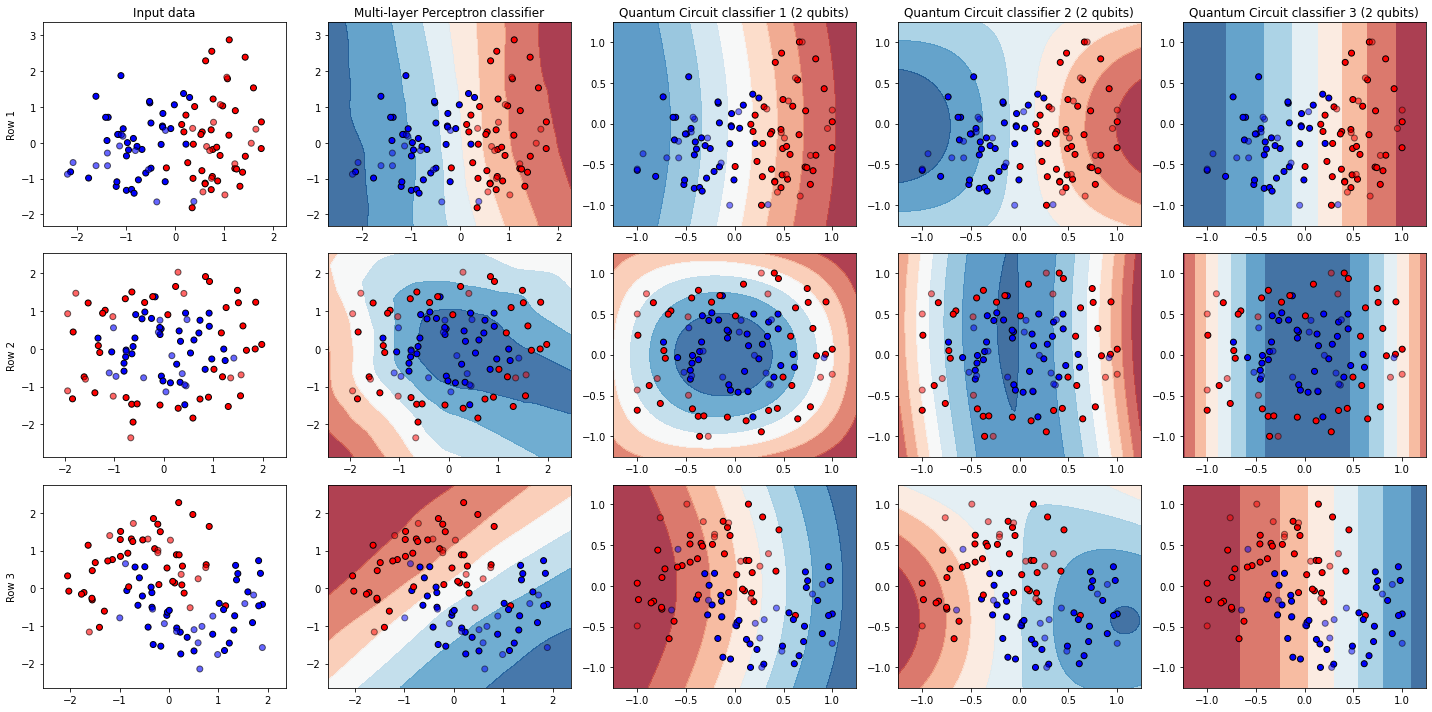

Loop count: 7


C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 0.4254750 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9300000 
Iter:     2 | Cost: 0.4231802 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9300000 
Iter:     3 | Cost: 0.4204507 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9300000 
Iter:     4 | Cost: 0.4185690 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:     5 | Cost: 0.4180164 | Acc train: 0.9466667 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:     6 | Cost: 0.4181695 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:     7 | Cost: 0.4187088 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:     8 | Cost: 0.4191372 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:     9 | Cost: 0.4193945 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:    10 | Cost: 0.4185952 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:    11 | Cost: 0.4178107 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.2183161 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.2177418 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.2169161 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:     4 | Cost: 1.2164795 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:     5 | Cost: 1.2187402 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5000000 
Iter:     6 | Cost: 1.2185080 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5000000 
Iter:     7 | Cost: 1.2178309 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.4800000 
Iter:     8 | Cost: 1.2185838 | Acc train: 0.5200000 | Acc val: 0.3600000 | Acc all: 0.4700000 
Iter:     9 | Cost: 1.2243402 | Acc train: 0.4800000 | Acc val: 0.3600000 | Acc all: 0.4500000 
Iter:    10 | Cost: 1.2369636 | Acc train: 0.4666667 | Acc val: 0.3200000 | Acc all: 0.4500000 
Iter:    11 | Cost: 1.2463984 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6813461 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     2 | Cost: 1.6830673 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     3 | Cost: 1.6863537 | Acc train: 0.3466667 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:     4 | Cost: 1.6919612 | Acc train: 0.3600000 | Acc val: 0.3600000 | Acc all: 0.3700000 
Iter:     5 | Cost: 1.6939681 | Acc train: 0.3733333 | Acc val: 0.3600000 | Acc all: 0.3800000 
Iter:     6 | Cost: 1.7029662 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:     7 | Cost: 1.7254400 | Acc train: 0.3066667 | Acc val: 0.4000000 | Acc all: 0.3300000 
Iter:     8 | Cost: 1.7514398 | Acc train: 0.2800000 | Acc val: 0.3600000 | Acc all: 0.3100000 
Iter:     9 | Cost: 1.7832940 | Acc train: 0.2800000 | Acc val: 0.3600000 | Acc all: 0.3100000 
Iter:    10 | Cost: 1.8096856 | Acc train: 0.3066667 | Acc val: 0.4000000 | Acc all: 0.3400000 
Iter:    11 | Cost: 1.8313386 | Acc trai

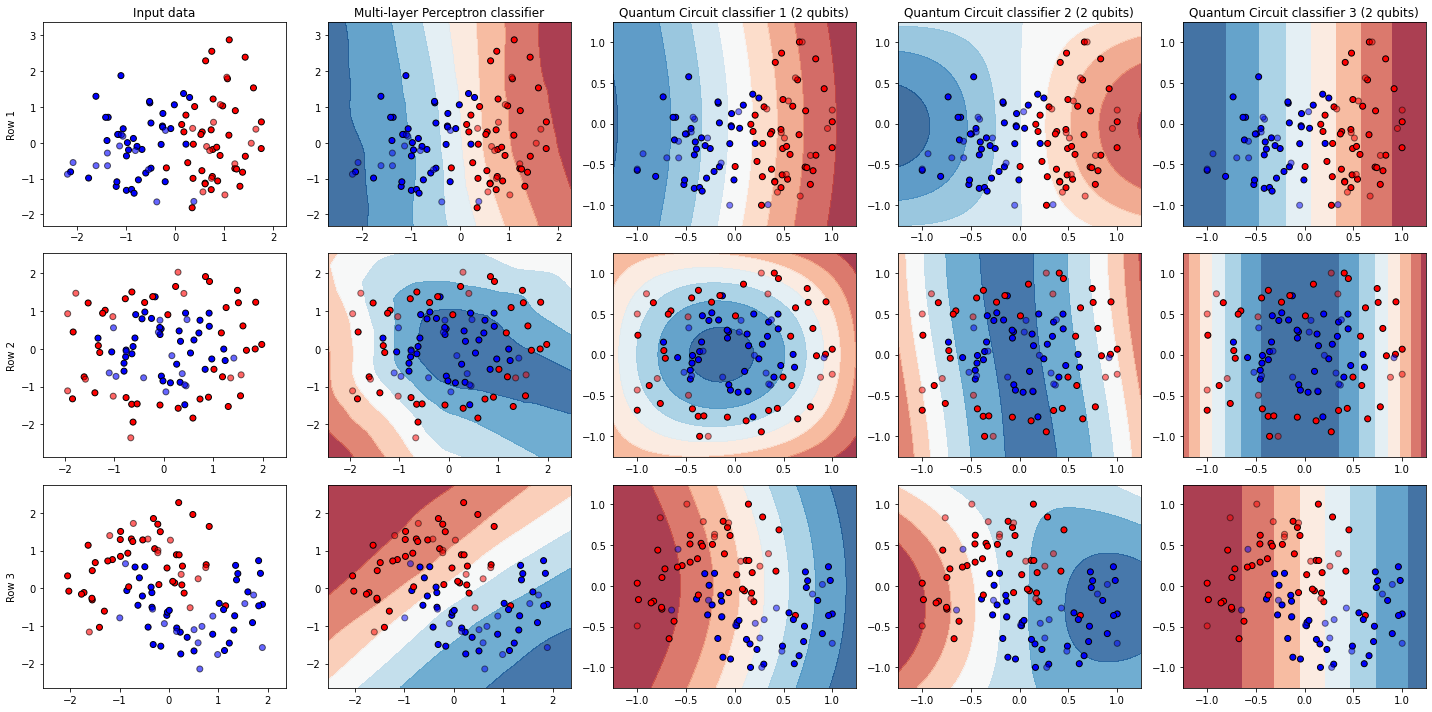

Loop count: 8


C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 0.4286598 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9200000 
Iter:     2 | Cost: 0.4266774 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9400000 
Iter:     3 | Cost: 0.4239164 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9300000 
Iter:     4 | Cost: 0.4226544 | Acc train: 0.9200000 | Acc val: 0.9600000 | Acc all: 0.9300000 
Iter:     5 | Cost: 0.4193145 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:     6 | Cost: 0.4175557 | Acc train: 0.9466667 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:     7 | Cost: 0.4168995 | Acc train: 0.9466667 | Acc val: 0.9600000 | Acc all: 0.9500000 
Iter:     8 | Cost: 0.4166929 | Acc train: 0.9466667 | Acc val: 0.9600000 | Acc all: 0.9500000 
Iter:     9 | Cost: 0.4169803 | Acc train: 0.9466667 | Acc val: 0.9600000 | Acc all: 0.9500000 
Iter:    10 | Cost: 0.4178055 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9500000 
Iter:    11 | Cost: 0.4198430 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.2194376 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.2196237 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.2202101 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.2193033 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.2169553 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5000000 
Iter:     6 | Cost: 1.2134925 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:     7 | Cost: 1.2105766 | Acc train: 0.5200000 | Acc val: 0.3600000 | Acc all: 0.5200000 
Iter:     8 | Cost: 1.2075208 | Acc train: 0.5333333 | Acc val: 0.4000000 | Acc all: 0.5100000 
Iter:     9 | Cost: 1.2069606 | Acc train: 0.5466667 | Acc val: 0.4400000 | Acc all: 0.5300000 
Iter:    10 | Cost: 1.2067223 | Acc train: 0.5466667 | Acc val: 0.4400000 | Acc all: 0.5400000 
Iter:    11 | Cost: 1.2097014 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6798615 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:     2 | Cost: 1.6796458 | Acc train: 0.3333333 | Acc val: 0.3600000 | Acc all: 0.3400000 
Iter:     3 | Cost: 1.6796399 | Acc train: 0.3333333 | Acc val: 0.3600000 | Acc all: 0.3400000 
Iter:     4 | Cost: 1.6795959 | Acc train: 0.3333333 | Acc val: 0.3600000 | Acc all: 0.3400000 
Iter:     5 | Cost: 1.6798864 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:     6 | Cost: 1.6809814 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     7 | Cost: 1.6860682 | Acc train: 0.3466667 | Acc val: 0.3600000 | Acc all: 0.3600000 
Iter:     8 | Cost: 1.6947945 | Acc train: 0.3733333 | Acc val: 0.3600000 | Acc all: 0.3700000 
Iter:     9 | Cost: 1.7060791 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:    10 | Cost: 1.7133209 | Acc train: 0.3066667 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:    11 | Cost: 1.7298046 | Acc trai

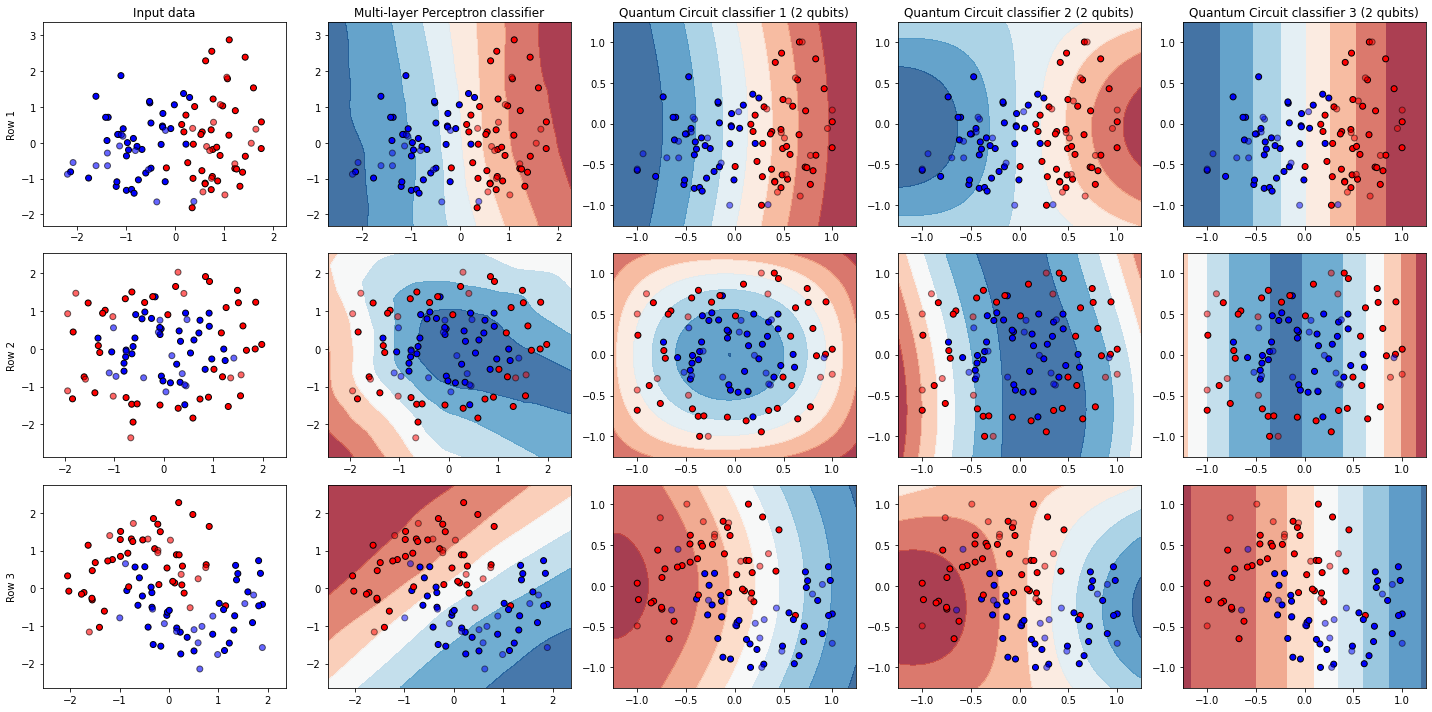

Loop count: 9


C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 0.4281117 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9300000 
Iter:     2 | Cost: 0.4232784 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9300000 
Iter:     3 | Cost: 0.4189266 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:     4 | Cost: 0.4169891 | Acc train: 0.9466667 | Acc val: 0.9600000 | Acc all: 0.9500000 
Iter:     5 | Cost: 0.4192583 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9500000 
Iter:     6 | Cost: 0.4229479 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:     7 | Cost: 0.4282939 | Acc train: 0.9200000 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:     8 | Cost: 0.4300518 | Acc train: 0.9200000 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:     9 | Cost: 0.4305021 | Acc train: 0.9200000 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:    10 | Cost: 0.4299719 | Acc train: 0.9200000 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:    11 | Cost: 0.4258476 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.2168394 | Acc train: 0.5200000 | Acc val: 0.3600000 | Acc all: 0.5200000 
Iter:     2 | Cost: 1.2155292 | Acc train: 0.5333333 | Acc val: 0.4000000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.2143512 | Acc train: 0.5333333 | Acc val: 0.4400000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.2133487 | Acc train: 0.5333333 | Acc val: 0.4400000 | Acc all: 0.5300000 
Iter:     5 | Cost: 1.2122793 | Acc train: 0.5333333 | Acc val: 0.4400000 | Acc all: 0.5300000 
Iter:     6 | Cost: 1.2136725 | Acc train: 0.5466667 | Acc val: 0.4400000 | Acc all: 0.5400000 
Iter:     7 | Cost: 1.2195971 | Acc train: 0.5600000 | Acc val: 0.4800000 | Acc all: 0.5600000 
Iter:     8 | Cost: 1.2349543 | Acc train: 0.6000000 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     9 | Cost: 1.2582129 | Acc train: 0.6133333 | Acc val: 0.5600000 | Acc all: 0.6100000 
Iter:    10 | Cost: 1.2919597 | Acc train: 0.6266667 | Acc val: 0.6000000 | Acc all: 0.6100000 
Iter:    11 | Cost: 1.3188823 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6803803 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     2 | Cost: 1.6830735 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     3 | Cost: 1.6843251 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     4 | Cost: 1.6846601 | Acc train: 0.3466667 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:     5 | Cost: 1.6830276 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     6 | Cost: 1.6815112 | Acc train: 0.3466667 | Acc val: 0.3200000 | Acc all: 0.3200000 
Iter:     7 | Cost: 1.6806278 | Acc train: 0.3466667 | Acc val: 0.3200000 | Acc all: 0.3200000 
Iter:     8 | Cost: 1.6787302 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     9 | Cost: 1.6766596 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:    10 | Cost: 1.6765254 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:    11 | Cost: 1.6787911 | Acc trai

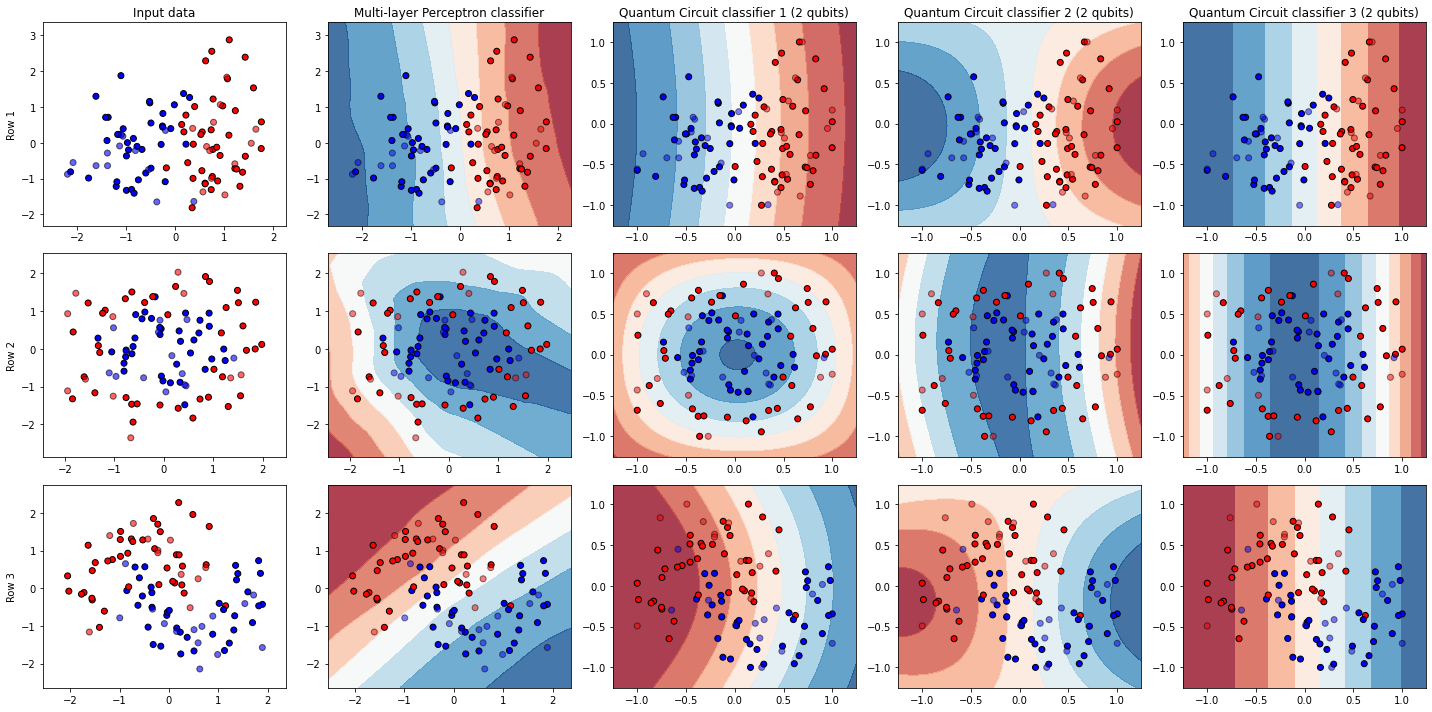

Loop count: 10


C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 0.4322044 | Acc train: 0.9333333 | Acc val: 0.9200000 | Acc all: 0.9200000 
Iter:     2 | Cost: 0.4348065 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9000000 
Iter:     3 | Cost: 0.4372184 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.8900000 
Iter:     4 | Cost: 0.4362189 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.8900000 
Iter:     5 | Cost: 0.4350858 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.8900000 
Iter:     6 | Cost: 0.4359037 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.8900000 
Iter:     7 | Cost: 0.4299438 | Acc train: 0.9333333 | Acc val: 0.9200000 | Acc all: 0.9200000 
Iter:     8 | Cost: 0.4279945 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9300000 
Iter:     9 | Cost: 0.4263806 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9400000 
Iter:    10 | Cost: 0.4272698 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9400000 
Iter:    11 | Cost: 0.4254777 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.2168454 | Acc train: 0.5200000 | Acc val: 0.3600000 | Acc all: 0.5200000 
Iter:     2 | Cost: 1.2156858 | Acc train: 0.5333333 | Acc val: 0.4000000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.2154618 | Acc train: 0.5333333 | Acc val: 0.4400000 | Acc all: 0.5300000 
Iter:     4 | Cost: 1.2158618 | Acc train: 0.5466667 | Acc val: 0.4400000 | Acc all: 0.5300000 
Iter:     5 | Cost: 1.2155886 | Acc train: 0.5333333 | Acc val: 0.4400000 | Acc all: 0.5300000 
Iter:     6 | Cost: 1.2134904 | Acc train: 0.5333333 | Acc val: 0.4400000 | Acc all: 0.5300000 
Iter:     7 | Cost: 1.2106056 | Acc train: 0.5466667 | Acc val: 0.4400000 | Acc all: 0.5300000 
Iter:     8 | Cost: 1.2090618 | Acc train: 0.5466667 | Acc val: 0.4400000 | Acc all: 0.5300000 
Iter:     9 | Cost: 1.2077525 | Acc train: 0.5333333 | Acc val: 0.4400000 | Acc all: 0.5300000 
Iter:    10 | Cost: 1.2085427 | Acc train: 0.5600000 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:    11 | Cost: 1.2127148 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6802890 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     2 | Cost: 1.6796210 | Acc train: 0.3333333 | Acc val: 0.3600000 | Acc all: 0.3400000 
Iter:     3 | Cost: 1.6794764 | Acc train: 0.3333333 | Acc val: 0.3600000 | Acc all: 0.3400000 
Iter:     4 | Cost: 1.6791873 | Acc train: 0.3466667 | Acc val: 0.3600000 | Acc all: 0.3500000 
Iter:     5 | Cost: 1.6793210 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:     6 | Cost: 1.6796627 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     7 | Cost: 1.6787749 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     8 | Cost: 1.6781377 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:     9 | Cost: 1.6777640 | Acc train: 0.3333333 | Acc val: 0.3600000 | Acc all: 0.3400000 
Iter:    10 | Cost: 1.6780069 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:    11 | Cost: 1.6807008 | Acc trai

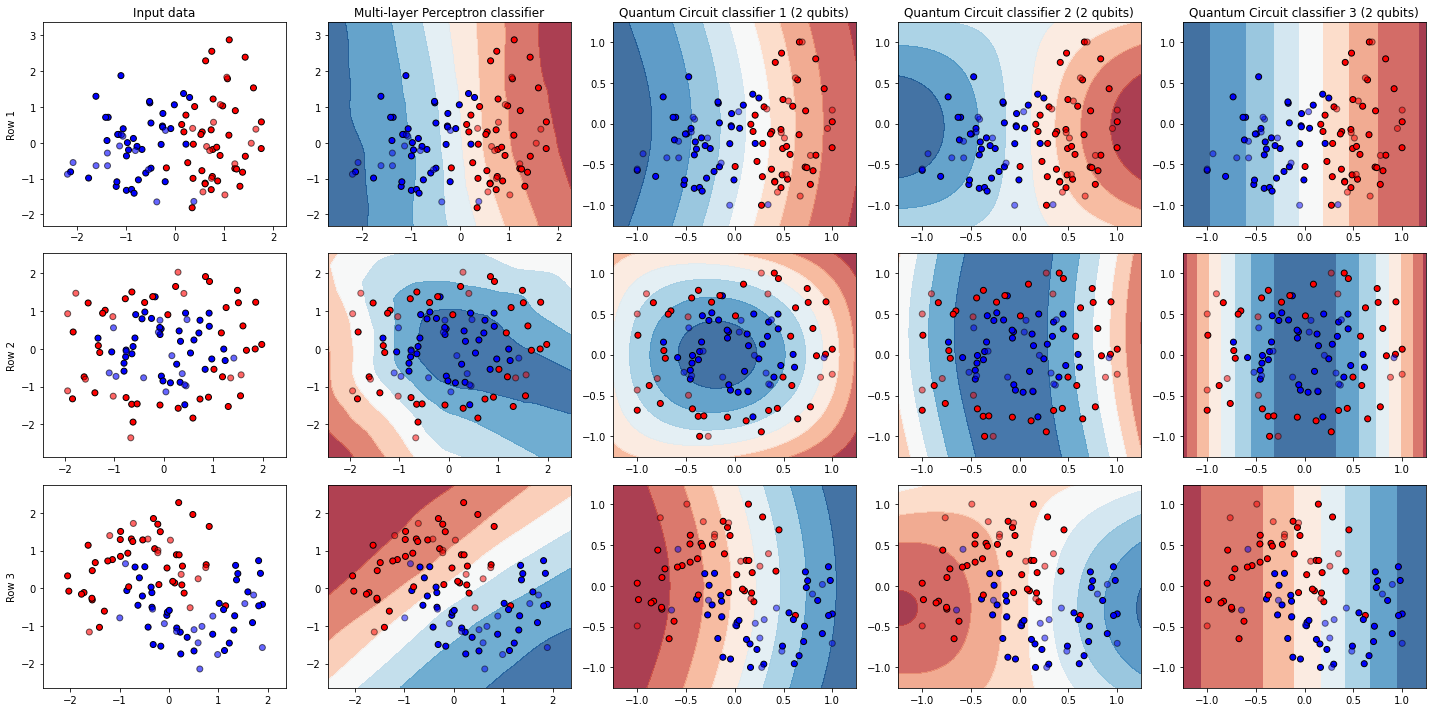

Loop count: 11


C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 0.4316719 | Acc train: 0.9333333 | Acc val: 0.9200000 | Acc all: 0.9200000 
Iter:     2 | Cost: 0.4357071 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.8900000 
Iter:     3 | Cost: 0.4409483 | Acc train: 0.8800000 | Acc val: 0.9200000 | Acc all: 0.8800000 
Iter:     4 | Cost: 0.4437444 | Acc train: 0.8666667 | Acc val: 0.9200000 | Acc all: 0.8800000 
Iter:     5 | Cost: 0.4486124 | Acc train: 0.8666667 | Acc val: 0.8800000 | Acc all: 0.8800000 
Iter:     6 | Cost: 0.4534133 | Acc train: 0.8666667 | Acc val: 0.8800000 | Acc all: 0.8800000 
Iter:     7 | Cost: 0.4599747 | Acc train: 0.8666667 | Acc val: 0.8800000 | Acc all: 0.8700000 
Iter:     8 | Cost: 0.4632642 | Acc train: 0.8666667 | Acc val: 0.8800000 | Acc all: 0.8700000 
Iter:     9 | Cost: 0.4639748 | Acc train: 0.8666667 | Acc val: 0.8800000 | Acc all: 0.8700000 
Iter:    10 | Cost: 0.4623210 | Acc train: 0.8666667 | Acc val: 0.8800000 | Acc all: 0.8700000 
Iter:    11 | Cost: 0.4594953 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.2209182 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.2188668 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.2173218 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:     4 | Cost: 1.2159807 | Acc train: 0.5200000 | Acc val: 0.3600000 | Acc all: 0.5200000 
Iter:     5 | Cost: 1.2165694 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:     6 | Cost: 1.2161491 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:     7 | Cost: 1.2157805 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5000000 
Iter:     8 | Cost: 1.2197662 | Acc train: 0.5200000 | Acc val: 0.3600000 | Acc all: 0.4600000 
Iter:     9 | Cost: 1.2319808 | Acc train: 0.4800000 | Acc val: 0.3600000 | Acc all: 0.4400000 
Iter:    10 | Cost: 1.2544532 | Acc train: 0.4666667 | Acc val: 0.3200000 | Acc all: 0.4400000 
Iter:    11 | Cost: 1.2709351 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6801251 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:     2 | Cost: 1.6793124 | Acc train: 0.3333333 | Acc val: 0.3600000 | Acc all: 0.3400000 
Iter:     3 | Cost: 1.6791241 | Acc train: 0.3466667 | Acc val: 0.3600000 | Acc all: 0.3500000 
Iter:     4 | Cost: 1.6794346 | Acc train: 0.3600000 | Acc val: 0.3600000 | Acc all: 0.3600000 
Iter:     5 | Cost: 1.6797215 | Acc train: 0.3600000 | Acc val: 0.3600000 | Acc all: 0.3500000 
Iter:     6 | Cost: 1.6825942 | Acc train: 0.3466667 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:     7 | Cost: 1.6886627 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:     8 | Cost: 1.6888175 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:     9 | Cost: 1.6977117 | Acc train: 0.3066667 | Acc val: 0.2800000 | Acc all: 0.3100000 
Iter:    10 | Cost: 1.7109595 | Acc train: 0.2933333 | Acc val: 0.3200000 | Acc all: 0.3000000 
Iter:    11 | Cost: 1.7198414 | Acc trai

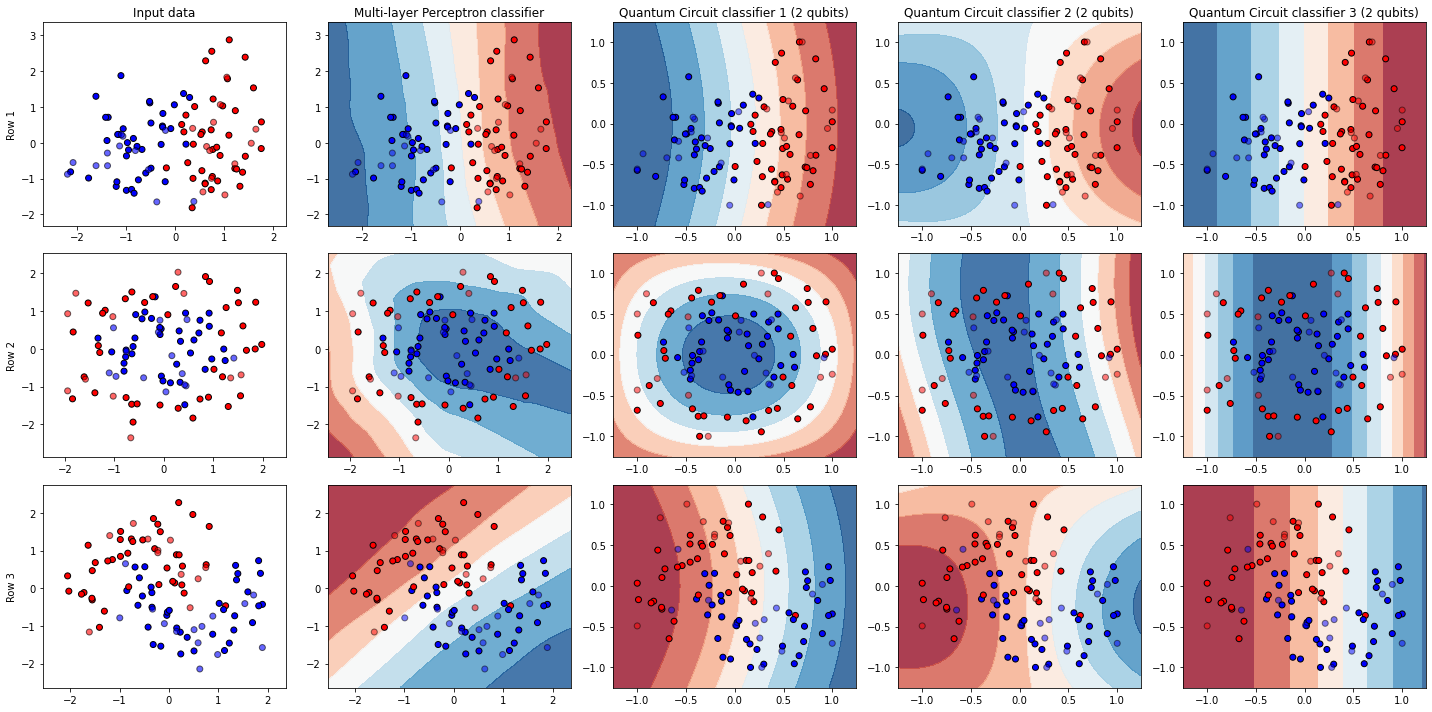

Loop count: 12


C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 0.4248395 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9300000 
Iter:     2 | Cost: 0.4198287 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:     3 | Cost: 0.4176865 | Acc train: 0.9466667 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:     4 | Cost: 0.4168719 | Acc train: 0.9466667 | Acc val: 0.9600000 | Acc all: 0.9500000 
Iter:     5 | Cost: 0.4169297 | Acc train: 0.9466667 | Acc val: 0.9600000 | Acc all: 0.9500000 
Iter:     6 | Cost: 0.4181642 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9500000 
Iter:     7 | Cost: 0.4192204 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:     8 | Cost: 0.4196403 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:     9 | Cost: 0.4217366 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:    10 | Cost: 0.4211534 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9300000 
Iter:    11 | Cost: 0.4203591 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.2209576 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.2190465 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.2179787 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:     4 | Cost: 1.2175316 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:     5 | Cost: 1.2184257 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5000000 
Iter:     6 | Cost: 1.2171831 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.4900000 
Iter:     7 | Cost: 1.2157338 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.4900000 
Iter:     8 | Cost: 1.2097335 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:     9 | Cost: 1.2045242 | Acc train: 0.5200000 | Acc val: 0.3600000 | Acc all: 0.5200000 
Iter:    10 | Cost: 1.2018625 | Acc train: 0.5333333 | Acc val: 0.4400000 | Acc all: 0.5200000 
Iter:    11 | Cost: 1.2006285 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6802220 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:     2 | Cost: 1.6807454 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     3 | Cost: 1.6832911 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     4 | Cost: 1.6910066 | Acc train: 0.3600000 | Acc val: 0.3600000 | Acc all: 0.3700000 
Iter:     5 | Cost: 1.6996903 | Acc train: 0.3600000 | Acc val: 0.3200000 | Acc all: 0.3500000 
Iter:     6 | Cost: 1.7086383 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:     7 | Cost: 1.7075078 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:     8 | Cost: 1.7035734 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:     9 | Cost: 1.6965254 | Acc train: 0.3733333 | Acc val: 0.3600000 | Acc all: 0.3700000 
Iter:    10 | Cost: 1.6883206 | Acc train: 0.3600000 | Acc val: 0.3600000 | Acc all: 0.3700000 
Iter:    11 | Cost: 1.6800586 | Acc trai

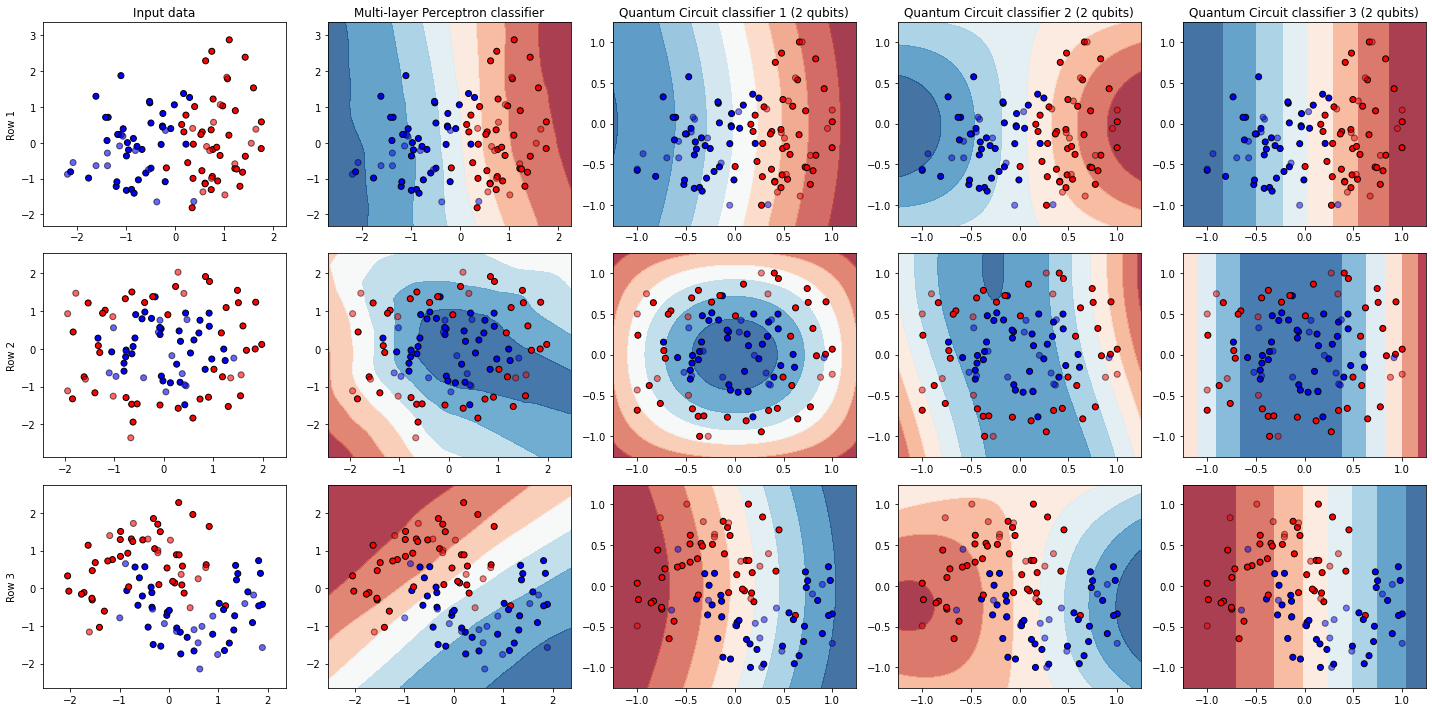

scores: [[[0.96 0.52 0.8 ]
  [0.96 0.52 0.8 ]
  [0.96 0.52 0.8 ]
  [0.96 0.52 0.8 ]
  [0.96 0.52 0.8 ]
  [0.96 0.52 0.8 ]
  [0.96 0.52 0.8 ]
  [0.96 0.52 0.8 ]
  [0.96 0.52 0.8 ]
  [0.96 0.52 0.8 ]
  [0.96 0.52 0.8 ]
  [0.96 0.52 0.8 ]
  [0.96 0.52 0.8 ]]

 [[0.96 0.84 0.64]
  [0.96 0.84 0.64]
  [0.92 0.84 0.72]
  [0.92 0.76 0.64]
  [0.96 0.88 0.68]
  [0.88 0.68 0.72]
  [0.96 0.76 0.64]
  [0.96 0.84 0.64]
  [0.96 0.84 0.72]
  [0.88 0.88 0.72]
  [0.92 0.44 0.64]
  [0.96 0.44 0.64]
  [0.96 0.88 0.64]]

 [[0.92 0.44 0.64]
  [0.96 0.6  0.68]
  [0.96 0.76 0.64]
  [1.   0.76 0.64]
  [0.92 0.76 0.68]
  [0.96 0.76 0.64]
  [0.96 0.68 0.64]
  [0.92 0.64 0.56]
  [1.   0.72 0.68]
  [0.96 0.44 0.68]
  [0.96 0.44 0.68]
  [1.   0.44 0.68]
  [0.96 0.44 0.72]]

 [[0.96 0.72 0.68]
  [0.92 0.72 0.68]
  [0.96 0.44 0.72]
  [0.96 0.44 0.64]
  [0.96 0.72 0.68]
  [0.96 0.72 0.68]
  [0.96 0.44 0.64]
  [0.96 0.44 0.68]
  [0.92 0.48 0.68]
  [0.96 0.76 0.64]
  [0.88 0.44 0.72]
  [0.92 0.44 0.64]
  [0.92 0.76 0.68

In [10]:
halfPi = pi/2
# h = 0.02  # step size in the mesh
h = 0.03  # step size in the mesh
n_samples = 100

names = [
    "Multi-layer Perceptron classifier",
    # "Linear SVM",
    "Quantum Circuit classifier 1 (2 qubits)",
    "Quantum Circuit classifier 2 (2 qubits)",
    "Quantum Circuit classifier 3 (2 qubits)",
]

classifiers = [
  MLPClassifier(random_state=1, max_iter=max_iterations, 
                    solver="sgd", nesterovs_momentum=True),
  # SVC(kernel="linear", C=0.025),
  [vc_quantum, vc_classifier_1, init_weights_1, circuit_1],
  [vc_quantum, vc_classifier_2, init_weights_2, circuit_2],
  [vc_quantum, vc_classifier_3, init_weights_3, circuit_3],
]

X, y = make_classification(
    n_samples=n_samples,
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
)
rng = numpy.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    linearly_separable,
    make_circles(n_samples=n_samples, noise=0.2, factor=0.5, random_state=1),
    make_moons(n_samples=n_samples, noise=0.3, random_state=0),
]

# initalize scores array
scores = np.zeros(shape=(len(classifiers),loop_count,len(datasets)))

#############
# Main Loop #
#############
for l_count in range(loop_count):
  print("Loop count:", l_count)
  figure = plt.figure(figsize=(20, 10))
  # Figure: set white background
  figure.patch.set_facecolor('xkcd:white')
  i = 1
  # iterate over datasets
  for ds_cnt, ds in enumerate(datasets):
      # preprocess dataset, split into training and test part
      X, y = ds

      X = StandardScaler().fit_transform(X)
      X_train, X_test, y_train, y_test = train_test_split(
          X, y, test_size=0.25, random_state=1
      )

      x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
      y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
      xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
      
      # scale data for quantum data
      y_train_quantum = np.where(y_train==0, y_train-1, y_train)
      y_test_quantum = np.where(y_test==0, y_test-1, y_test)
      y_quantum = np.where(y==0, y-1, y)
      
      scale_value=1
      X_scaled = MinMaxScaler(feature_range=(-scale_value,scale_value), copy=True).fit_transform(X)
      X_train_scaled = MinMaxScaler(feature_range=(-scale_value,scale_value), copy=True).fit_transform(X_train)
      X_test_scaled = MinMaxScaler(feature_range=(-scale_value,scale_value), copy=True).fit_transform(X_test)

      x_min_scaled, x_max_scaled = X_scaled[:, 0].min() - 0.25, X_scaled[:, 0].max() + 0.25
      y_min_scaled, y_max_scaled = X_scaled[:, 1].min() - 0.25, X_scaled[:, 1].max() + 0.25
      xx_scaled, yy_scaled = np.meshgrid(np.arange(x_min_scaled, x_max_scaled, h), np.arange(y_min_scaled, y_max_scaled, h))

      # just plot the dataset first
      cm = plt.cm.RdBu
      cm_bright = ListedColormap(["#FF0000", "#0000FF"])
      ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
      if ds_cnt == 0:
          ax.set_title("Input data")
      ax.set(ylabel='Row ' + str(ds_cnt+1))
      # Plot the training points
      ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
      # Plot the testing points
      ax.scatter(
          X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
      )
      ax.set_xlim(xx.min(), xx.max())
      ax.set_ylim(yy.min(), yy.max())
      # ax.set_xticks(())
      # ax.set_yticks(())
      i += 1

      classifier_count=0
      # iterate over classifiers
      for name, clf in zip(names, classifiers):
          
          ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
          
          if 'Quantum' in name:
            # Quantum circuit #
            vars, score = clf[0](clf[1], clf[2], X_train_scaled, X_test_scaled, X_scaled, y_train_quantum, y_test_quantum, y_quantum)
            Z = np.array(
              [clf[1](vars, f) for f in np.c_[xx_scaled.ravel(), yy_scaled.ravel()]]
            )

            # Put the result into a color plot
            Z = Z.reshape(xx_scaled.shape)
            ax.contourf(xx_scaled, yy_scaled, Z, cmap=cm, alpha=0.8)
            
            # Plot the training points
            ax.scatter(
                X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train_quantum, cmap=cm_bright, edgecolors="k"
            )
            # Plot the testing points
            ax.scatter(
                X_test_scaled[:, 0],
                X_test_scaled[:, 1],
                c=y_test_quantum,
                cmap=cm_bright,
                edgecolors="k",
                alpha=0.5,
            )
            
            ax.set_xlim(xx_scaled.min(), xx_scaled.max())
            ax.set_ylim(yy_scaled.min(), yy_scaled.max())

            # print scores
            # ax.text(
            #   xx_scaled.max() - 0.15,
            #   yy_scaled.min() + 0.15,
            #   ("Score: %.2f" % score).lstrip("0"),
            #   size=15,
            #   horizontalalignment="right",
            # )
            
          else:
            # Classical circuits #
            clf.fit(X_train, y_train)
            score = clf.score(X_test, y_test)

            # Plot the decision boundary. For that, we will assign a color to each
            # point in the mesh [x_min, x_max]x[y_min, y_max].
            if hasattr(clf, "decision_function"):
                Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
            else:
                Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

            # Put the result into a color plot
            Z = Z.reshape(xx.shape)
            ax.contourf(xx, yy, Z, cmap=cm, alpha=0.8)
                
            # Plot the training points
            ax.scatter(
                X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
            )
            # Plot the testing points
            ax.scatter(
                X_test[:, 0],
                X_test[:, 1],
                c=y_test,
                cmap=cm_bright,
                edgecolors="k",
                alpha=0.5,
            )

            ax.set_xlim(xx.min(), xx.max())
            ax.set_ylim(yy.min(), yy.max())

            # print scores
            # ax.text(
            #     xx.max() - 0.3,
            #     yy.min() + 0.3,
            #     ("Score: %.2f" % score).lstrip("0"),
            #     size=15,
            #     horizontalalignment="right",
            # )
            
          scores[classifier_count][l_count][ds_cnt] = score
          # ax.set_xticks(())
          # ax.set_yticks(())
          if ds_cnt == 0:
              ax.set_title(name)
          i += 1
          classifier_count += 1

  plt.tight_layout()
  plt.show()

print("scores:", scores)


In [11]:
for name, clf in zip(names, classifiers):
    if 'Quantum' in name:
      print(name)
      print(clf[3].draw())


Quantum Circuit classifier 1 (2 qubits)
 0: ──H──RY(1.24)──╭C──Rot(0.0049, 2.88, 0.00437)───────╭C──┤ ⟨Z⟩ 
 1: ──H──RY(1.24)──╰X──Rot(0.0178, -0.00103, -0.00633)──╰X──┤     

Quantum Circuit classifier 2 (2 qubits)
 0: ──H──RY(1.24)──RX(1.24)──╭C──Rot(-0.502, 2.66, -0.00292)────────╭C──┤ ⟨Z⟩ 
 1: ──H──────────────────────╰X──Rot(6.8e-05, -0.000319, -0.00618)──╰X──┤     

Quantum Circuit classifier 3 (2 qubits)
 0: ──H──RY(1.24)──╭C──Rot(0.00593, 2.78, 0.0208)───────╭C──┤ ⟨Z⟩ 
 1: ──H──RX(1.24)──╰X──Rot(-0.00894, 0.0135, -0.00743)──╰X──┤     



C:\Users\zero\anaconda3\lib\site-packages\pennylane\qnode.py:838: UserWarning: The QNode.draw method has been deprecated. Please use the qml.draw(qnode)(*args) function instead.
  warnings.warn(
